# Computing the cross correlation function (CCF)

[Feature Engineering for Time Series Forecasting](https://www.trainindata.com/p/feature-engineering-for-forecasting)

In this notebook we show how we can compute the CCF and CCF plots on various toy time series to understand how the CCF behaves.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)) and the air passengers data set (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_air_passengers.csv))

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1 and 4, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The retail sales dataset is a monthly timeseries representing sales volumes collected between January 1992 and May 2016.
The air passengers dataset is a monthly timeseries representing the number of US air passengers collected between January 1949 and December 1960.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.seasonal import STL

sns.set_context("talk")

# Helper functions

In [2]:
def plot_ccf(x, y, lags):
    # Compute CCF and confidence interval
    cross_corrs = ccf(x, y)
    ci = 2 / np.sqrt(len(y))
    # Create plot
    fig, ax = plt.subplots(figsize=[10, 5])
    ax.stem(range(0, lags + 1), cross_corrs[: lags + 1])
    ax.fill_between(range(0, lags + 1), ci, y2=-ci, alpha=0.2)
    ax.set_title("Cross-correlation")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    return ax

In [3]:
def lag_plot(x, y, lag, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=[5, 5])
    ax.scatter(y=y, x=x.shift(periods=lag), s=10)
    ax.set_ylabel("$y_t$")
    ax.set_xlabel(f"$x_{{t-{lag}}}$")
    return ax

# Computing the CCF for a white noise timeseries

Let's compute the CCF between two white noise time series so there is no predictive information in any historic point:

$$y_t = \epsilon_t$$ 
$$x_t = \alpha_t$$ 

where $$\epsilon_{t}, \alpha_{t}  \sim  N(mean, std)$$

We expect the cross-correlation function to be small at all lags as each data point is completely independent of each other.

Let's create the time series.

In [4]:
num_timesteps = 1000  # Length of time series we want
np.random.seed(0)  # Ensures we generate the same random numbers every time

y = np.random.normal(loc=0, scale=1, size=num_timesteps)
x = np.random.normal(loc=0, scale=1, size=num_timesteps)
ts = pd.date_range(start="2000-01-01", periods=num_timesteps, freq="D")

df = pd.DataFrame(data={"y": y, "x": x}, index=ts)
df.head()

,y,x
2000-01-01,1.764052,0.555963
2000-01-02,0.400157,0.892474
2000-01-03,0.978738,-0.422315
2000-01-04,2.240893,0.104714
2000-01-05,1.867558,0.228053


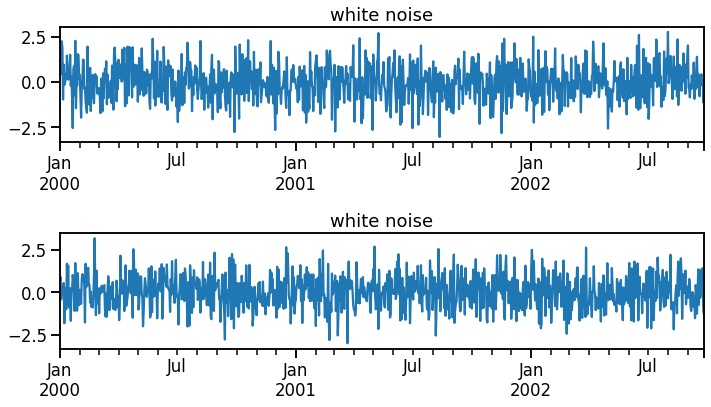

In [5]:
# Plot the two time series
fig, ax = plt.subplots(nrows=2, figsize=[10, 6])
df["y"].plot(y=["y"], ax=ax[0])
df["x"].plot(y=["x"], ax=ax[1])
ax[0].set_title("white noise")
ax[1].set_title("white noise")

plt.tight_layout()

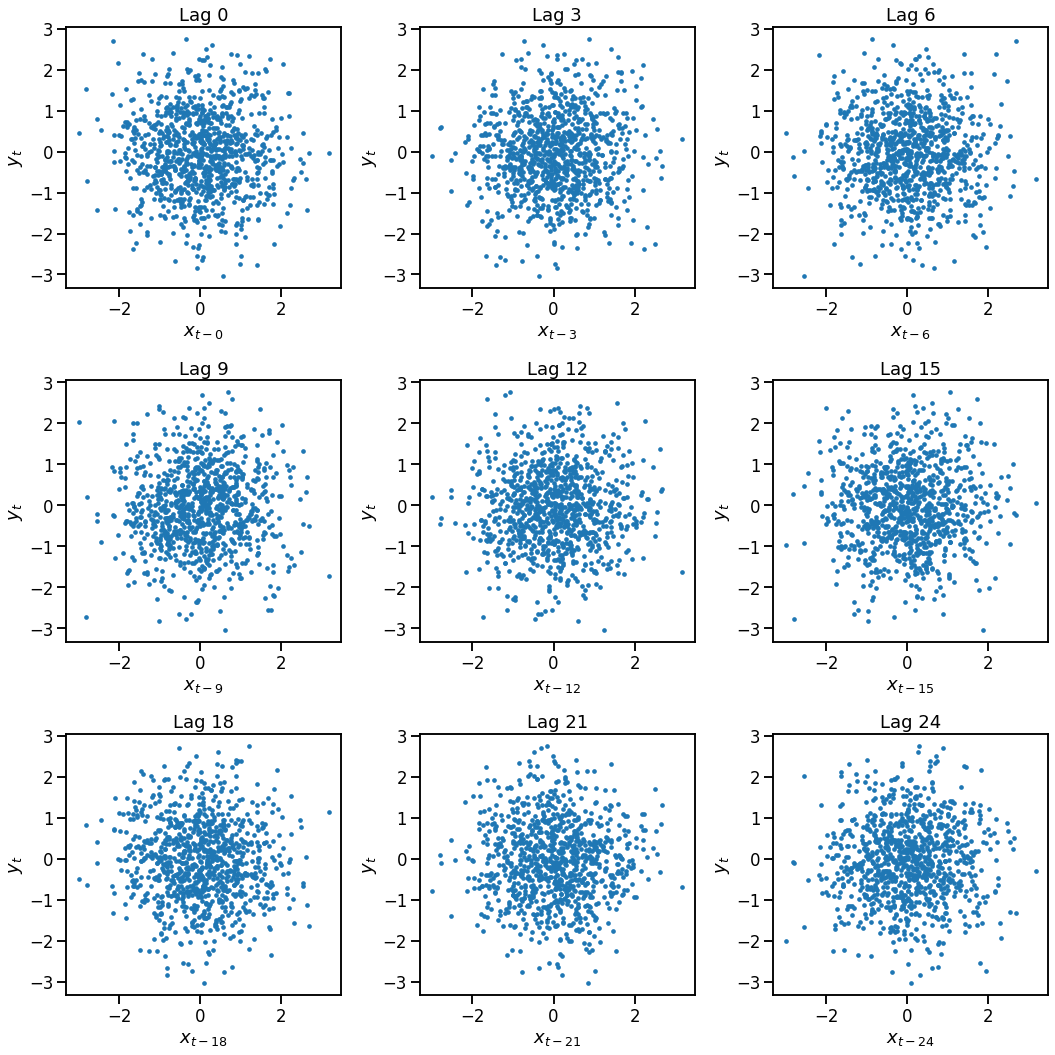

In [6]:
# Plot a lag plot
fig, ax = plt.subplots(3, 3, figsize=[15, 15])
axs = ax.flatten()
for ix, lag in enumerate(range(0, 27, 3)):
    ax = lag_plot(y=df["y"], x=df["x"], lag=lag, ax=axs[ix])
    ax.set_title(f"Lag {lag}")
plt.tight_layout()

Let's plot the CCF.

Text(0.5, 0, 'Lag')

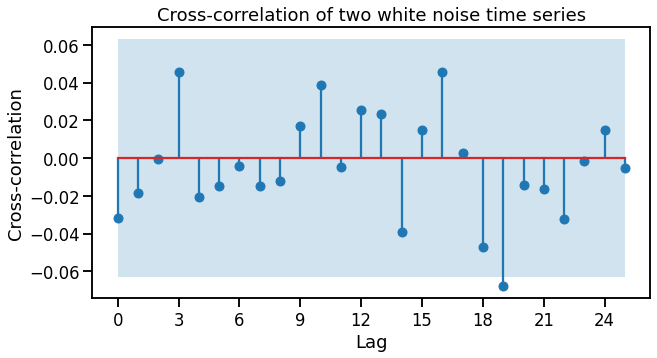

In [7]:
ax = plot_ccf(df["y"], df["x"], lags=25)
ax.set_title("Cross-correlation of two white noise time series")
ax.set_ylabel("Cross-correlation")
ax.set_xlabel("Lag")

As expected the cross-correlation is small and not signifcant across most lags. By chance we expect some lags to be larger than the confidence interval so the fact that we see some lags just outside of the interval is not something to give attention to.

# Time series with lag p

Let's create a toy time series $y_t$ where we expect some correlation with the lag of a different time series $x_t$. For fun, let's start with a time series which follows an AR1 process for $x_t$. We then create a time series $y_t$ which depends on lag p of $x_t$ and add some additional noise.

$$x_t = \phi_{xx} x_{{t-1}} + \epsilon_t$$ $$y_t = \phi_{yx} x_{{t-p}} + \alpha_t$$ where $$\epsilon_t, \alpha_t  \sim  N(mean=0, std=1)$$

Let's create both time series.

In [8]:
# Initial parameters
num_timesteps = 1000  # Length of time series we want
np.random.seed(0)  # Ensures we generate the same random numbers every time
p = 10
phi_yx = 3
phi_xx = 0.9
ts = pd.date_range(start="2000-01-01", periods=num_timesteps, freq="D")

# Generate time series
x = np.zeros(num_timesteps)
y = np.zeros(num_timesteps)

# Generate x
for t in range(1, num_timesteps):
    noise = np.random.normal()
    x[t] = phi_xx * x[t - 1] + noise

# Generate y
for t in range(p, num_timesteps):
    noise = np.random.normal()
    y[t] = phi_yx * x[t - p] + noise

df = pd.DataFrame(data={"y": y[p:], "x": x[p:]}, index=ts[p:])
df.head()

,y,x
2000-01-11,-0.358114,3.864013
2000-01-12,5.848120,3.621656
2000-01-13,6.855887,4.713764
2000-01-14,7.880971,5.003425
2000-01-15,14.300351,4.624757


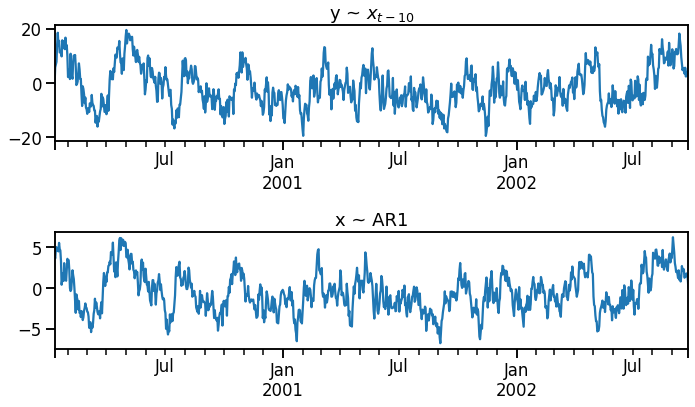

In [9]:
# Plot the two time series
fig, ax = plt.subplots(nrows=2, figsize=[10, 6])
df["y"].plot(y=["y"], ax=ax[0])
df["x"].plot(y=["x"], ax=ax[1])
ax[0].set_title(f"y ~ $x_{{t-{p}}}$")
ax[1].set_title("x ~ AR1")

plt.tight_layout()

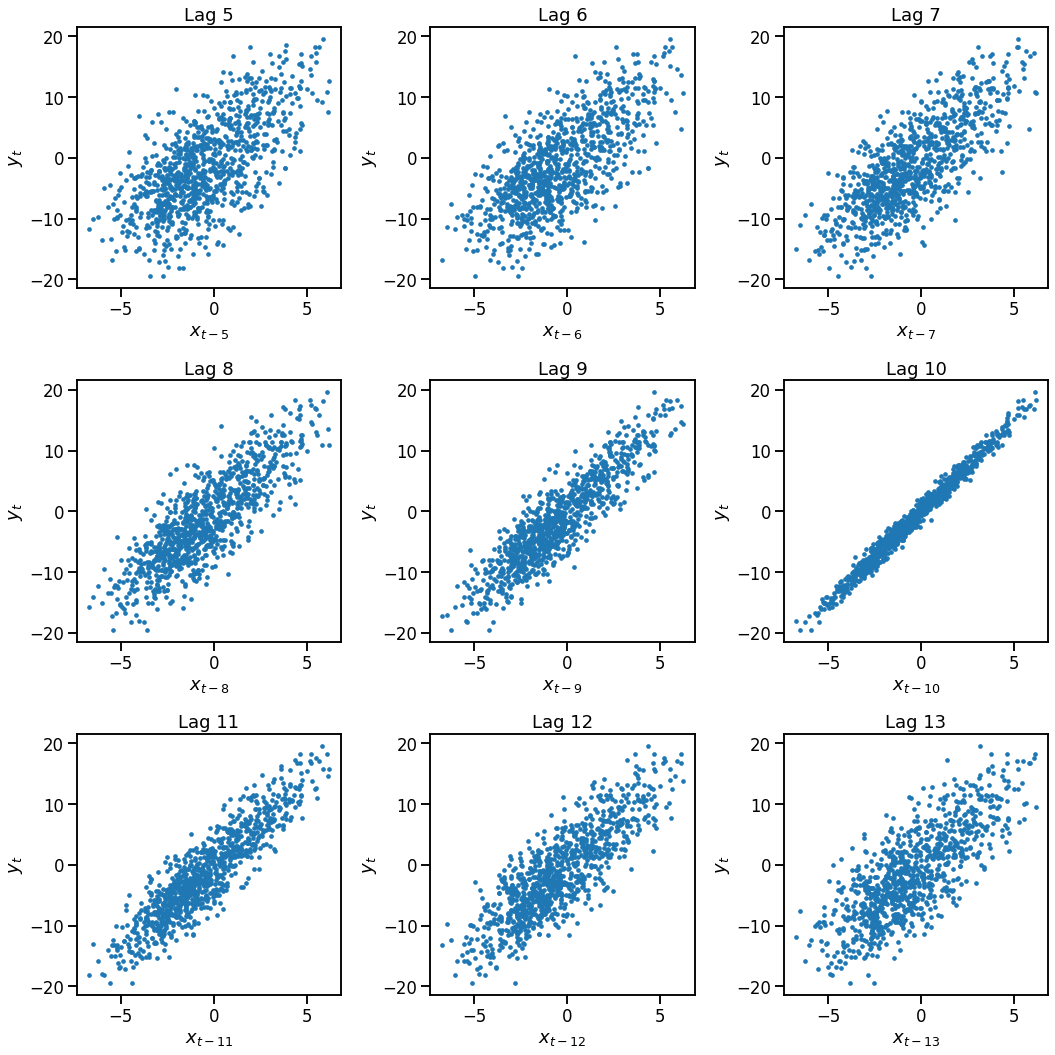

In [10]:
# Plot a lag plot
fig, ax = plt.subplots(3, 3, figsize=[15, 15])
axs = ax.flatten()
for ix, lag in enumerate(range(max(0, p - 5), p + 4)):
    ax = lag_plot(y=df["y"], x=df["x"], lag=lag, ax=axs[ix])
    ax.set_title(f"Lag {lag}")
plt.tight_layout()

Text(0.5, 0, 'Lag')

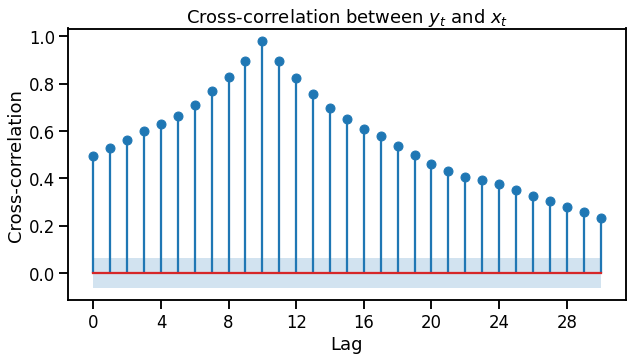

In [11]:
ax = plot_ccf(df["y"], df["x"], lags=30)
ax.set_title("Cross-correlation between $y_t$ and $x_t$")
ax.set_ylabel("Cross-correlation")
ax.set_xlabel("Lag")

We see many significant lags despite the fact that only one is important. Nevertheless, we see that the CCF peaks at the lag of p allowing us to determine that it is an important lag!

# Time series with trend and seasonality

In this section we will show that just having a trend component between two time series will create cross-correlations between the two series, even if the two time series have nothing to do with one another and hence we would probably not want to use one as a predictor of the other.


We will look at the retail and air passengers dataset. These were collected over different decades and so we don't expect one will be predictive of the other. We will align them by the start date and look at the first 120 observations.

In [12]:
df_air_passengers = pd.read_csv("../Datasets/example_air_passengers.csv", nrows=120)
df_retail_sales = pd.read_csv("../Datasets/example_retail_sales.csv", nrows=120)

In [13]:
df = pd.DataFrame(data={"air": df_air_passengers["y"], "retail": df_retail_sales["y"]})

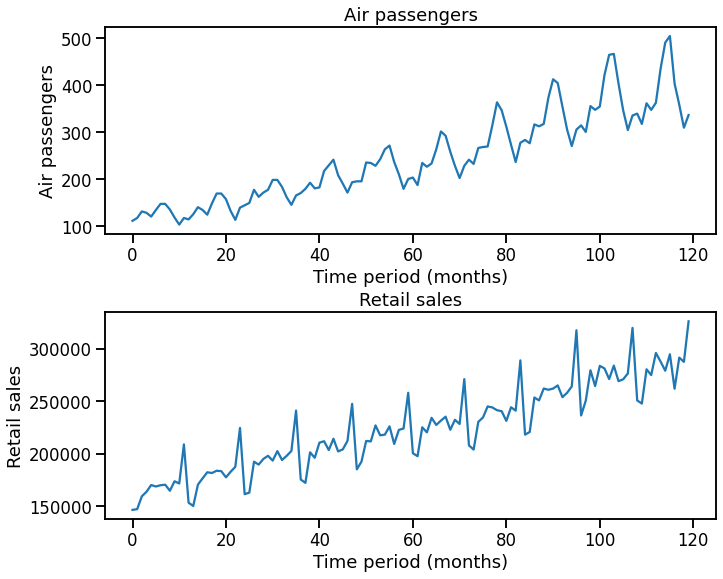

In [21]:
# Plot the two time series
fig, ax = plt.subplots(nrows=2, figsize=[10, 8])
df["air"].plot(y=["air"], ax=ax[0])
ax[0].set_xlabel("Time period (months)")
ax[0].set_ylabel("Air passengers")
ax[0].set_title("Air passengers")

df["retail"].plot(y=["retail"], ax=ax[1])
ax[1].set_xlabel("Time period (months)")
ax[1].set_ylabel("Retail sales")
ax[1].set_title("Retail sales")

plt.tight_layout()

Text(0.5, 0, 'Lag')

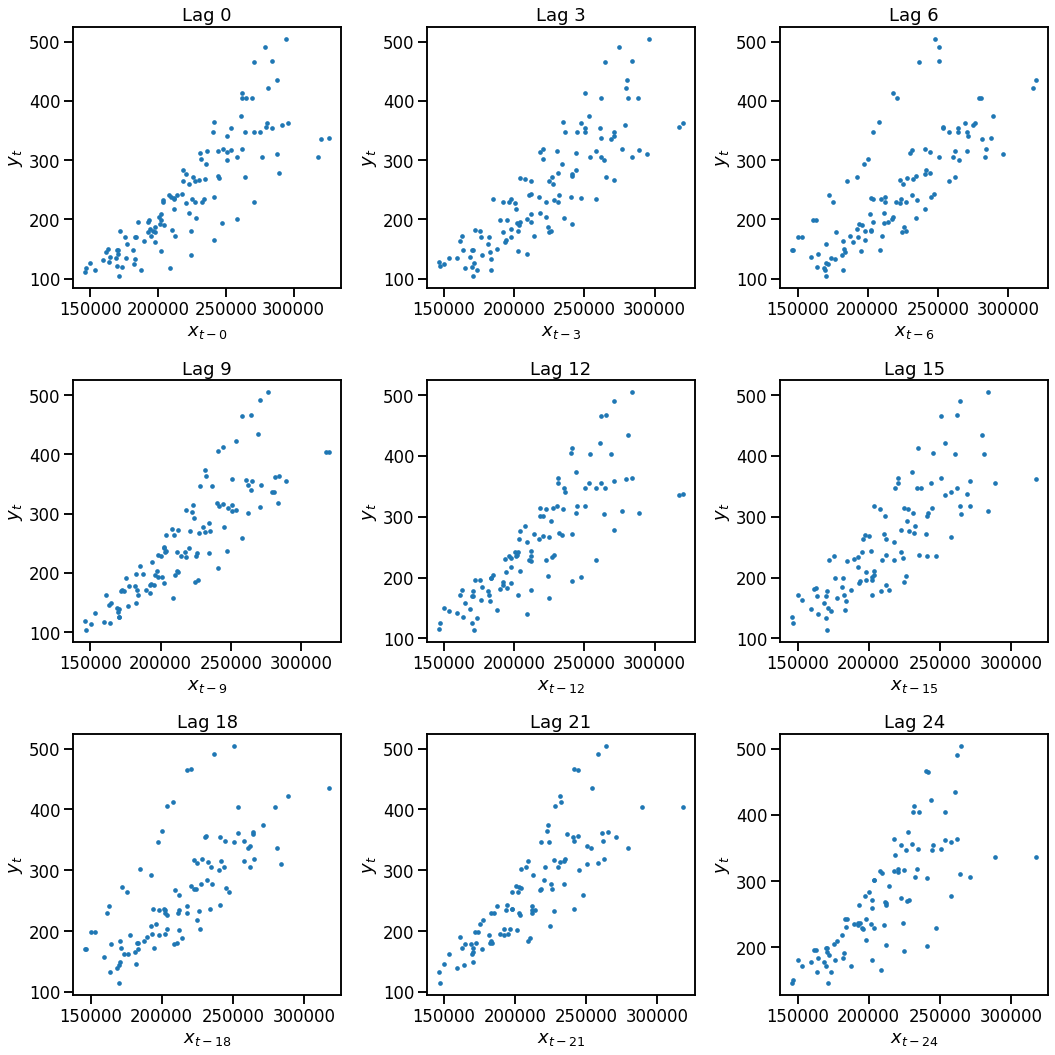

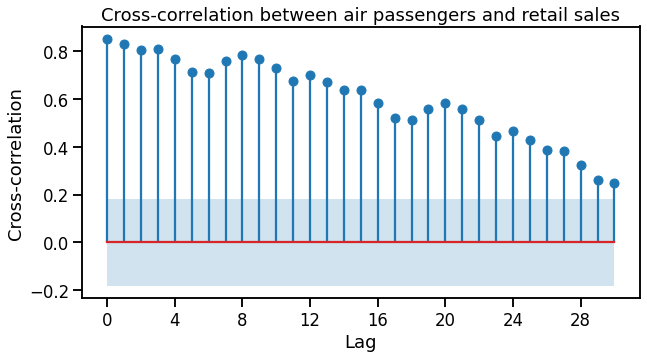

In [15]:
# Plot a lag plot
fig, ax = plt.subplots(3, 3, figsize=[15, 15])
axs = ax.flatten()
for ix, lag in enumerate(range(0, 27, 3)):
    ax = lag_plot(y=df["air"], x=df["retail"], lag=lag, ax=axs[ix])
    ax.set_title(f"Lag {lag}")
plt.tight_layout()

# Plot the CCF
ax = plot_ccf(df["air"], df["retail"], lags=30)
ax.set_title("Cross-correlation between air passengers and retail sales")
ax.set_ylabel("Cross-correlation")
ax.set_xlabel("Lag")

We see many significant lags in the CCF due to the trend. We also see oscillations in the CCF as both time series have seasonality. 


This shows that we should try to make the data stationary (e.g., by detrending, deseasonalising, stabilising the variance through a log transform if needed) before measuring the CCF between two time series. 



Let's check of there is any cross-correlation after removing the trend and seasonal components of both of these series using STL.

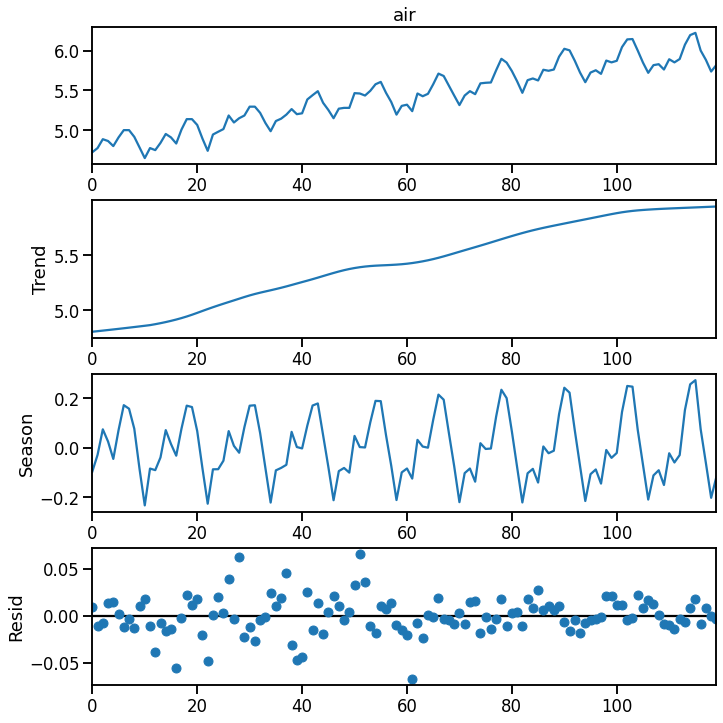

In [23]:
# The air passengers dataset has the variance increase with time suggesting
# a multiplicative model. So we shall take the log of the series for STL as
# STL assumes an decomposition (i.e., y = trend + seasonal + residual)
stl_air = STL(np.log(df['air']), period=12).fit()
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
ax = stl_air.plot()

This looks like a reasonable decomposition by visual inspection (i.e., the trend looks reasonable, the seasonality is sensible and we see dips and peaks that are mirrored in the observed data, the residuals look randomly scattered about y=0).

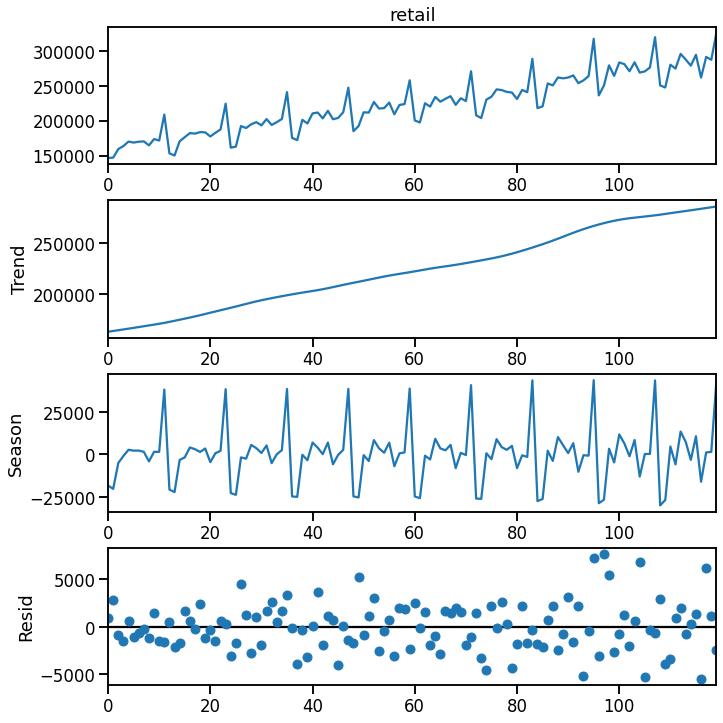

In [17]:
stl_retail = STL(df['retail'], period=12).fit()
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
ax = stl_retail.plot()

This looks like a reasonable decomposition by visual inspection (i.e., the trend looks reasonable, the seasonality is sensible and we see dips and peaks that are mirrored in the observed data, the residuals look randomly scattered about y=0).

The residuals are the original time series subtracted by trend and seasonality. So the residuals would be the de-trended and de-seasonalised time series for this example. Let's look at the CCF of the residuals between these two time series.

Text(0.5, 0, 'Lag')

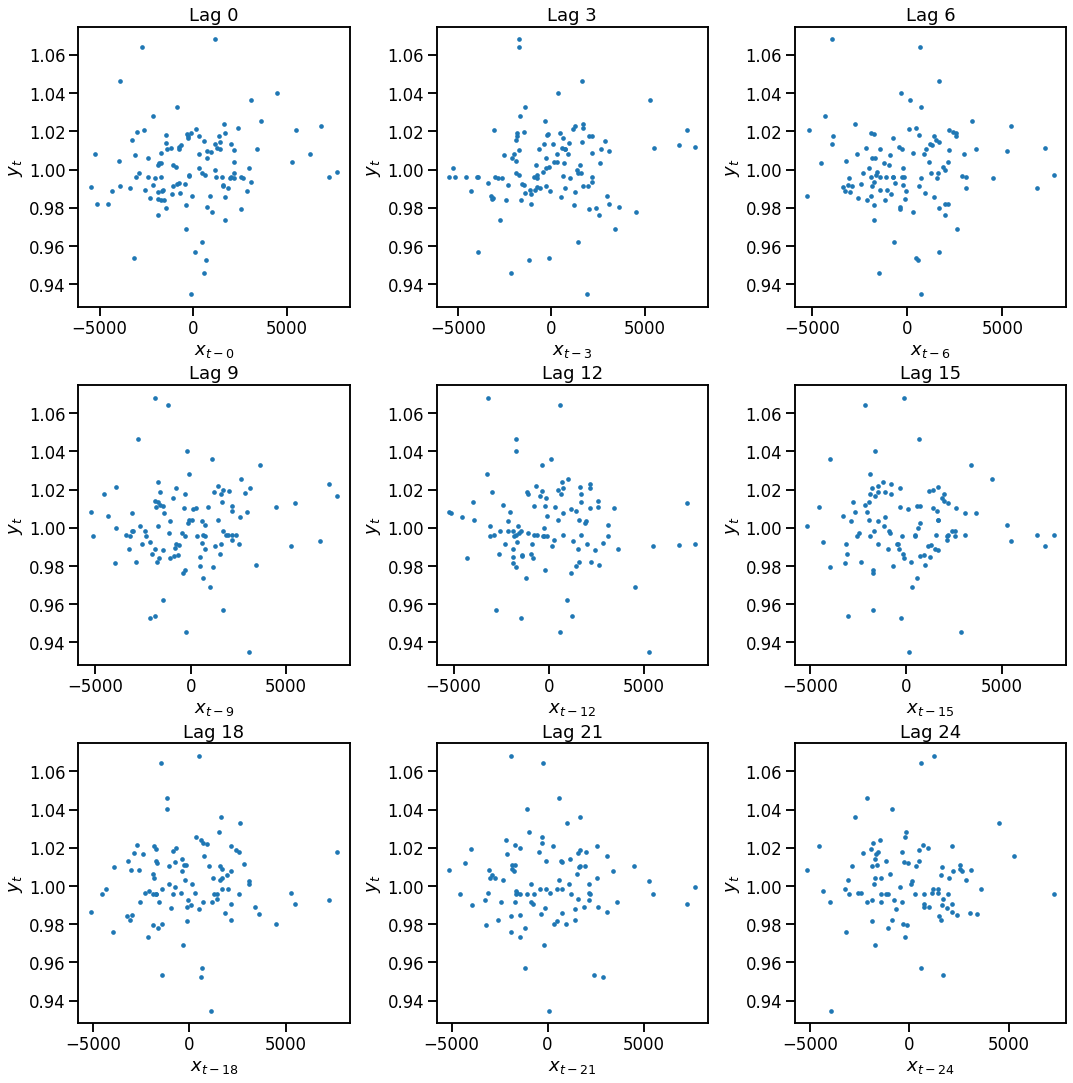

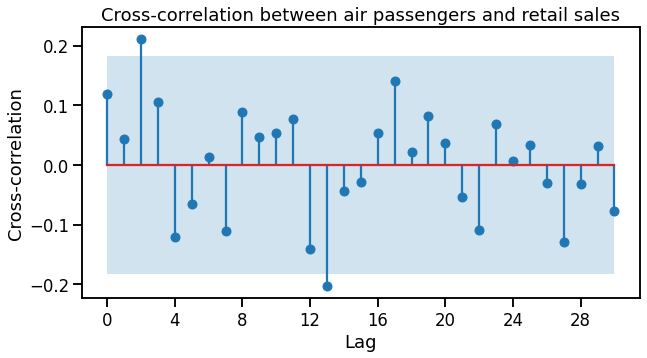

In [24]:
# Detrended and deseasonalised time series
air = np.exp(stl_air.resid) # To convert back into correct 
                            # units after taking log transform before
retail = stl_retail.resid

# Plot a lag plot
fig, ax = plt.subplots(3, 3, figsize=[15, 15])
axs = ax.flatten()
for ix, lag in enumerate(range(0, 27, 3)):
    ax = lag_plot(y=air, x=retail, lag=lag, ax=axs[ix])
    ax.set_title(f"Lag {lag}")
plt.tight_layout()

# Plot CCF
ax = plot_ccf(air, retail, lags=30)
ax.set_title("Cross-correlation between air passengers and retail sales")
ax.set_ylabel("Cross-correlation")
ax.set_xlabel("Lag")

The lag plots show much less correlation now, if any at all. This is reflected in the CCF. There are very few significant lags and none which are very large beyond the confidence interval. This demonstrates that there is not much information in one of these time series to predict the other, as we would expect.

Now we understand how the CCF behaves we shall cover a much more challenging time series in notebook 8 to demonstrate a more realistic use case.